## 1.1. Import the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import cv2
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50


import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [3]:
# Verify the dataset structure
print("Dataset structure:")
for dirname, _, filenames in os.walk('/kaggle/input/flowers-dataset'):
    for filename in filenames[:1]:  # Show only first file in each directory
        print(os.path.join(dirname, filename))

# Create working directory for models
if not os.path.exists('/kaggle/working/models'):
    os.makedirs('/kaggle/working/models')

Dataset structure:
/kaggle/input/flowers-dataset/Flowers/test/dandelion/5716633491_55e6f02645_n.jpg
/kaggle/input/flowers-dataset/Flowers/test/sunflowers/14646279002_9cdf97be97_n.jpg
/kaggle/input/flowers-dataset/Flowers/test/daisy/5133243796_44de429de5_m.jpg
/kaggle/input/flowers-dataset/Flowers/test/roses/2501297526_cbd66a3f7e_m.jpg
/kaggle/input/flowers-dataset/Flowers/test/tulips/16677542612_a78a8ca8b3_m.jpg
/kaggle/input/flowers-dataset/Flowers/train/dandelion/2625836599_03e192266f.jpg
/kaggle/input/flowers-dataset/Flowers/train/sunflowers/8249000137_eddfffa380_n.jpg
/kaggle/input/flowers-dataset/Flowers/train/daisy/8882282142_9be2524d38_m.jpg
/kaggle/input/flowers-dataset/Flowers/train/roses/6108118824_5b0231a56d.jpg
/kaggle/input/flowers-dataset/Flowers/train/tulips/8757486380_90952c5377.jpg


## 1.2. Read the Data

In [4]:
# # Data setini okuyalim ve ilgili pathlere atayalim; 
train_path = "/kaggle/input/flowers-dataset/Flowers/train"
test_path = "/kaggle/input/flowers-dataset/Flowers/test"

# submission = pd.read_csv("/kaggle/input/flowers-dataset/sample_submission.csv")

class_names = os.listdir(train_path)
class_names

['dandelion', 'sunflowers', 'daisy', 'roses', 'tulips']

In [5]:
# Count total train images
total_train = 0
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(train_path + "/" + i)))
    total_train += len(os.listdir(train_path + "/" + i))
print("Total train images : ", total_train)

Number of Dandelion images: 718
Number of Sunflowers images: 559
Number of Daisy images: 506
Number of Roses images: 512
Number of Tulips images: 639
Total train images :  2934


In [6]:
# Count total test images
total_test = 0
for i in class_names:
    print("Number of", i.capitalize(), "images:", len(os.listdir(test_path + "/" + i)))
    total_test += len(os.listdir(test_path + "/" + i))
print("Total test images : ", total_test)

Number of Dandelion images: 180
Number of Sunflowers images: 140
Number of Daisy images: 127
Number of Roses images: 129
Number of Tulips images: 160
Total test images :  736


## 1.3. Data preparation: Split Train Data as X and y

2


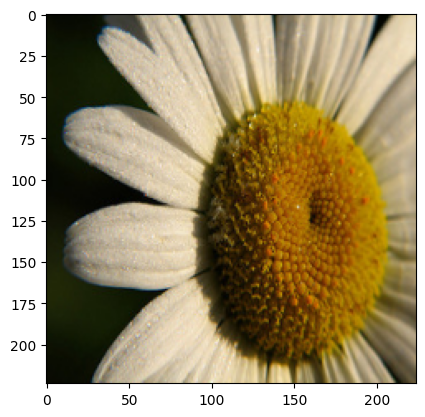

In [7]:
X = np.empty((total_train, 224, 224, 3), dtype = np.float32)
y = np.zeros(total_train, dtype = np.int64)
count = 0

for i, class_name in enumerate(class_names):
    
    class_path = os.path.join(train_path, class_name)
    
    for image_name in os.listdir(class_path):
        
        image_path = os.path.join(class_path, image_name)
        image = imread(image_path)
        image = cv2.resize(image, (224, 224))
        
        X[count] = image 
        y[count] = i
        count = count + 1
        
print(y[1501])
plt.imshow(X[1501] / 255);

## 1.4. Data preparation: Split Train Data as X_train, y_train, X_test and y_test¶

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)
del X, y

## 1.5. Data Augmentation

In [9]:
# For Custom CNN use full Image Generation so that to obtain more image quantity for better model training. 

data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),keras.layers.RandomRotation(factor=0.2),
                                      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                                      layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
                                      layers.RandomBrightness(factor=0.1),
                                      layers.RandomContrast(factor=0.1)])

## 2. SET THE CUSTOM CNN MODEL (basic_model)

In [10]:
# We didn't scale our data before. We apllied it in here. 

inputs = keras.Input(shape = (224, 224, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x) # bu x'i yukaridan alip buraya getiriyoruz. Rscaling islemini burada uyguluyoruz. 

x = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(x)
x = layers.Conv2D(filters = 64, kernel_size = (5, 5), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding = "same", activation = "relu")(x)
x = layers.Conv2D(filters=128, kernel_size=(5, 5), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

#----ANN----------

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

outputs = layers.Dense(5, activation = "softmax")(x)

basic_model = keras.Model(inputs, outputs)
basic_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 848,517 (3.24 MB)

 Trainable params: 847,493 (3.23 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [11]:
# to select the weights for the epoch with the highest val_score

class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [12]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [13]:
# Let this be the first training phase;
# First make LR = 0.1, let it learn fast, take it like epoch 5 and train it. Do this a few times. If you can change LR and epoch, change it slightly. Continue without training the part with X above.
# It keeps in mind the weights it learned in this line 

basic_model.compile(optimizer = optimizers.Adam(learning_rate = 0.1), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = basic_model.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/5


2024-11-06 11:07:35.895715: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 270ms/step - accuracy: 0.2607 - loss: 2.1182 - val_accuracy: 0.1721 - val_loss: 23.5437
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.3842 - loss: 1.4045 - val_accuracy: 0.2198 - val_loss: 5.3409
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.4538 - loss: 1.2832 - val_accuracy: 0.3373 - val_loss: 2.2006
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - accuracy: 0.4079 - loss: 1.3152 - val_accuracy: 0.3901 - val_loss: 1.4957
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.3987 - loss: 1.3232 - val_accuracy: 0.3850 - val_loss: 2.1874


In [14]:
# Run this second;
# Here you can decrease LR, increase Epoch a little
# In the second run, it continues to work from where it left off (accuracy value of the one above). 

basic_model.compile(optimizer = optimizers.Adam(learning_rate = 0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = basic_model.fit(X_train, y_train, epochs = 5, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/5


2024-11-06 11:09:20.069816: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - accuracy: 0.4882 - loss: 1.2007 - val_accuracy: 0.5111 - val_loss: 1.2116
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.4958 - loss: 1.1922 - val_accuracy: 0.4940 - val_loss: 1.2593
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5342 - loss: 1.1229 - val_accuracy: 0.3799 - val_loss: 1.4645
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.5336 - loss: 1.1126 - val_accuracy: 0.4327 - val_loss: 1.4254
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5538 - loss: 1.0827 - val_accuracy: 0.5009 - val_loss: 1.2272


In [15]:
#MAKE A CHANGE ONLY HERE TO IMPROVE THE SCORE
# # Just make this block LR=0.0001 epoch = 100 and run it to learn in more detail.

basic_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history = basic_model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

# It is not certain that it will improve the score, but it will save time.

Epoch 1/100


2024-11-06 11:10:52.454102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 240ms/step - accuracy: 0.4931 - loss: 1.1793 - val_accuracy: 0.5434 - val_loss: 1.1499
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5259 - loss: 1.1543 - val_accuracy: 0.5417 - val_loss: 1.1367
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5275 - loss: 1.1260 - val_accuracy: 0.5537 - val_loss: 1.1398
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5374 - loss: 1.1140 - val_accuracy: 0.5503 - val_loss: 1.1361
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5510 - loss: 1.1104 - val_accuracy: 0.5792 - val_loss: 1.0776
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5498 - loss: 1.0965 - val_accuracy: 0.5894 - val_loss: 1.0574
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5722 - loss: 1.0930 - val_accuracy: 0.5826 - val_loss: 1.0465
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.5570 - loss: 1.0701 - val_accuracy

## 2.1. Fine tuning the custom CNN model

In [16]:
# Fine tuning. The information from the base model is in its memory. 
# In this stage, it will learn how to make the weights in its memory better. That's why we do "fine tuning". 

basic_model.trainable = True

# We did 2 things as Fine Tuning ---> 
# 1) trainable =True
# 2) Reduce LR

basic_model.compile(optimizer = optimizers.Adam(1e-5), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # Adam(1e-5) LR = 0.00001 
basic_model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25


2024-11-06 11:27:09.367799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.6484 - loss: 0.9055 - val_accuracy: 0.6797 - val_loss: 0.8811
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6496 - loss: 0.8944 - val_accuracy: 0.6831 - val_loss: 0.8810
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6612 - loss: 0.8797 - val_accuracy: 0.6814 - val_loss: 0.8790
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6602 - loss: 0.8655 - val_accuracy: 0.6797 - val_loss: 0.8788
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6639 - loss: 0.8951 - val_accuracy: 0.6780 - val_loss: 0.8781
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6765 - loss: 0.8571 - val_accuracy: 0.6814 - val_loss: 0.8779
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6557 - loss: 0.8875 - val_accuracy: 0.6814 - val_loss: 0.8776
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - accuracy: 0.6249 - loss: 0.9523 - val_accuracy: 0.681

## 2.2. Evaluate the custom CNN model

In [17]:
basic_model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7207 - loss: 0.8098


[0.873823881149292, 0.6831345558166504]

In [18]:
train_proba = basic_model.predict(X_train)
train_prediction = np.argmax(train_proba, axis=1)

val_proba = basic_model.predict(X_test)
val_prediction = np.argmax(val_proba, axis=1)

print("TEST RESULTS")
print(confusion_matrix(y_test, val_prediction))
print(classification_report(y_test, val_prediction))
print("------------------------------")
print("TRAIN RESULTS")
print(confusion_matrix(y_train, train_prediction))
print(classification_report(y_train, train_prediction))

74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
TEST RESULTS
[[123   8   7   4   2]
 [ 12  88   3   5   4]
 [ 24   2  63  10   2]
 [ 25   0   1  51  25]
 [ 17   6  10  19  76]]
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       144
           1       0.85      0.79      0.81       112
           2       0.75      0.62      0.68       101
           3       0.57      0.50      0.53       102
           4       0.70      0.59      0.64       128

    accuracy                           0.68       587
   macro avg       0.70      0.67      0.68       587
weighted avg       0.69      0.68      0.68       587

------------------------------
TRAIN RESULTS
[[479  46  31   5  13]
 [ 52 356  10   8  21]
 [ 76   8 289  17  15]
 [ 62  15  29 204 100]
 [ 48  26  20  72 345]]
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       574
           1       0.79      0.8

## 2.1. Save the custom CNN model

In [21]:
from tensorflow.keras.models import load_model

# Save the model architecture
basic_model_json = basic_model.to_json()
with open("models/basic_model.json", "w") as json_file:
    json_file.write(basic_model_json)

# Savethe model weights
basic_model.save_weights("models/basic_model.weights.h5") 

# 3. Transfer learning models

## 3.1. VGG16 model

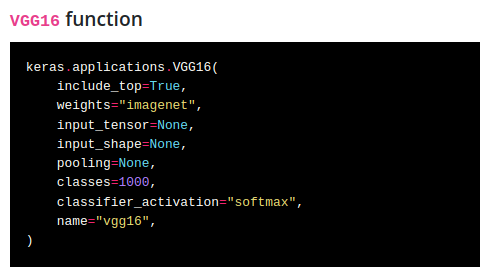

In [22]:
# Short version of Image Generator; 
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.2)])

## 3.1.1. Setting the base model for VGG16

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

# Base Model;
base_model = applications.VGG16(input_shape = (224, 224, 3), include_top = False) # include_top = False denilince ANN kismini biz yapabiliyoruz. True dersek ANN'i de yapar.  
base_model.trainable = False

inputs = keras.Input(shape = (224, 224, 3)) 
x = data_augmentation(inputs)
x = applications.vgg16.preprocess_input(x)  # BUNU preprosessing icin ekledik. Boylece modelde yer almayan rescaling islemi burada yapilacak!!!  
x = base_model(x, training = False)
# Buraya yeni katmanlar ekleyebiliriz ama overfite dikkat et !!!

"""
BURADA BAZI DENEMELER YAPTIM 
# 1. asama olarak; Buradaki kodlari ekledim skorlar iyilessin diye
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding = "same", activation = "relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)               #  ama ACC 1 - 0.89 oldu, overfitting ortaya cikti.  """


# Flatten
x = keras.layers.GlobalAveragePooling2D()(x)


# ---ANN---

"""
2. asamada yalin haliyle acc 0.96 -- 0.89 cikti.
3. asamada alttakini ekledim; acc 0.93 / 0.85 oldu 

x = keras.layers.Dense(128, activation="relu")(x) # Bu hidden layerleri ben ekledim skor iyiessin diye. 
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x) """

outputs = keras.layers.Dense(5, activation = "softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      2,565 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Bu kod bloku en iyi skoru veren Epoch'un agirliklarini kullanmamizi sagliyor. 

class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [25]:
# Best Model;

best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# Let's compile the VGG16 model;
model.compile(optimizer = optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# Train the model history;
history = model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.2788 - loss: 4.4223 - val_accuracy: 0.6763 - val_loss: 1.4609
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6703 - loss: 1.2513 - val_accuracy: 0.7632 - val_loss: 1.0084
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.7348 - loss: 0.8494 - val_accuracy: 0.7819 - val_loss: 0.8493
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.7853 - loss: 0.7253 - val_accuracy: 0.7990 - val_loss: 0.7406
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8224 - loss: 0.5824 - val_accuracy: 0.8058 - val_loss: 0.6973
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8541 - loss: 0.4559 - val_accuracy: 0.8075 - val_loss: 0.6538
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8541 - loss: 0.3969 - val_accuracy: 0.8160 - val_loss: 0.6284
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8768 - loss: 0.3708 - val_accuracy: 0

## 3.1.2. Fine-tuning VGG16 model

In [26]:
base_model.trainable = True # Base modelde val_los un min oldugu yerdeki agirliklarin kullanilmasina izin verdik
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

model.compile(optimizer = optimizers.Adam(1e-5), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 27s 281ms/step - accuracy: 0.9185 - loss: 0.2189 - val_accuracy: 0.9012 - val_loss: 0.4131
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9380 - loss: 0.1546 - val_accuracy: 0.9114 - val_loss: 0.3671
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9549 - loss: 0.1134 - val_accuracy: 0.9165 - val_loss: 0.3892
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9633 - loss: 0.1149 - val_accuracy: 0.9233 - val_loss: 0.3469
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9759 - loss: 0.0764 - val_accuracy: 0.9302 - val_loss: 0.3518
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9777 - loss: 0.0559 - val_accuracy: 0.9267 - val_loss: 0.3459
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.9863 - loss: 0.0457 - val_accuracy: 0.9267 - val_loss: 0.4034
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 0.9866 - loss: 0.0403 - val_accu

## 3.1.3. Evaluating VGG16 model

In [27]:
train_proba = model.predict(X_train)
train_prediction = np.argmax(train_proba, axis=1)

val_proba = model.predict(X_test)
val_prediction = np.argmax(val_proba, axis=1)

print("TEST RESULTS")
print(confusion_matrix(y_test, val_prediction))
print(classification_report(y_test, val_prediction))
print("------------------------------")
print("TRAIN RESULTS")
print(confusion_matrix(y_train, train_prediction))
print(classification_report(y_train, train_prediction))

74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
TEST RESULTS
[[141   2   0   0   1]
 [  2 108   0   1   1]
 [  4   1  93   3   0]
 [  2   0   0  97   3]
 [  2   3   1   6 116]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       144
           1       0.95      0.96      0.96       112
           2       0.99      0.92      0.95       101
           3       0.91      0.95      0.93       102
           4       0.96      0.91      0.93       128

    accuracy                           0.95       587
   macro avg       0.95      0.94      0.95       587
weighted avg       0.95      0.95      0.95       587

------------------------------
TRAIN RESULTS
[[574   0   0   0   0]
 [  0 447   0   0   0]
 [  1   0 403   0   1]
 [  0   0   1 407   2]
 [  0   0   0   4 507]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       574
           1       1.00      1.0

## 3.1.4. Saving VGG16 model

In [29]:
from tensorflow.keras.models import load_model
model.save('models/VGG16.keras')

## 3.2. ResNet152 model

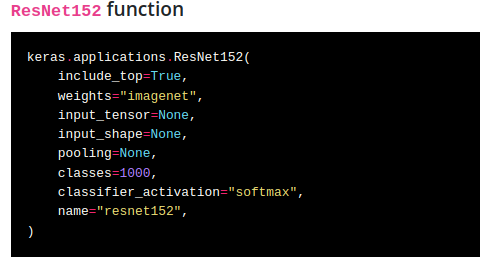

In [30]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.2)])

## 3.2.1. Setting the base model for ResNet152

In [31]:
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions

# Base Model;
base_model = applications.ResNet152(input_shape = (224, 224, 3), include_top = False,)
base_model.trainable = False

inputs = keras.Input(shape = (224, 224, 3))
x = data_augmentation(inputs)
# x = layers.Rescaling(1/255)(x)     # rescaling icin sadece bu yetmiyor. "https://keras.io/api/applications/resnet/#resnet152-function" Burada RGB'den BGR'a donusturmekten de bahsediyor. O yuzden altsatirdaki kodu kullanacagiz.  
x = applications.resnet.preprocess_input(x)  # Bunu preprosessing (rescaling) icin ekledik. ResNet152 seklinde yazinca kabul etmiyor.
x = base_model(x, training = False)

#---Flatten yerine---
x = keras.layers.GlobalAveragePooling2D()(x)

#---ANN---
outputs = keras.layers.Dense(5, activation = "softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 7, 7,      │ 58,370,944 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │     10,245 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,381,189 (222.71 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [32]:
# Bu kod bloku en iyi skoru veren Epoch'un agirliklarini kullanmamizi sagliyor. 

class GetBestModel(keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [33]:
# Best Model;
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

# Let's compile the ResNet152 model;
model.compile(optimizer = optimizers.Adam(), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# Train the model history;
history = model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.6129 - loss: 1.0141 - val_accuracy: 0.8842 - val_loss: 0.3306
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.8808 - loss: 0.3369 - val_accuracy: 0.9080 - val_loss: 0.2745
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - accuracy: 0.9017 - loss: 0.2707 - val_accuracy: 0.9182 - val_loss: 0.2371
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9106 - loss: 0.2438 - val_accuracy: 0.9097 - val_loss: 0.2567
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9298 - loss: 0.1940 - val_accuracy: 0.9148 - val_loss: 0.2384
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - accuracy: 0.9246 - loss: 0.1904 - val_accuracy: 0.9199 - val_loss: 0.2211
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 229ms/step - accuracy: 0.9527 - loss: 0.1554 - val_accuracy: 0.9216 - val_loss: 0.2374
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.9562 - loss: 0.1313 - val_accu

## 3.2.2. Fine-tuning ResNet152 model

In [35]:
base_model.trainable = True

model.compile(optimizer = optimizers.Adam(1e-5), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(X_train, y_train, epochs = 25, validation_data = (X_test, y_test), callbacks = [early_stop, best_model])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 178s 886ms/step - accuracy: 0.8893 - loss: 0.3171 - val_accuracy: 0.9336 - val_loss: 0.2096
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 773ms/step - accuracy: 0.9520 - loss: 0.1377 - val_accuracy: 0.9404 - val_loss: 0.1918
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 773ms/step - accuracy: 0.9723 - loss: 0.0983 - val_accuracy: 0.9353 - val_loss: 0.1854
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 774ms/step - accuracy: 0.9735 - loss: 0.0812 - val_accuracy: 0.9302 - val_loss: 0.1817
Epoch 5/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 773ms/step - accuracy: 0.9876 - loss: 0.0580 - val_accuracy: 0.9370 - val_loss: 0.1707
Epoch 6/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 769ms/step - accuracy: 0.9952 - loss: 0.0358 - val_accuracy: 0.9404 - val_loss: 0.1717
Epoch 7/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 773ms/step - accuracy: 0.9970 - loss: 0.0295 - val_accuracy: 0.9489 - val_loss: 0.1676
Epoch 8/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 57s 774ms/step - accuracy: 0.9933 - loss: 0.0290 - val_acc

## 3.2.3. Evaluating ResNet152 model

In [36]:
train_proba = model.predict(X_train)
train_prediction = np.argmax(train_proba, axis=1)

val_proba = model.predict(X_test)
val_prediction = np.argmax(val_proba, axis=1)

print("TEST RESULTS")
print(confusion_matrix(y_test, val_prediction))
print(classification_report(y_test, val_prediction))
print("------------------------------")
print("TRAIN RESULTS")
print(confusion_matrix(y_train, train_prediction))
print(classification_report(y_train, train_prediction))

74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step
TEST RESULTS
[[141   0   3   0   0]
 [  1 107   2   1   1]
 [  3   0  94   3   1]
 [  2   1   0  94   5]
 [  1   2   0   5 120]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       144
           1       0.97      0.96      0.96       112
           2       0.95      0.93      0.94       101
           3       0.91      0.92      0.92       102
           4       0.94      0.94      0.94       128

    accuracy                           0.95       587
   macro avg       0.95      0.94      0.95       587
weighted avg       0.95      0.95      0.95       587

------------------------------
TRAIN RESULTS
[[574   0   0   0   0]
 [  1 446   0   0   0]
 [  0   0 405   0   0]
 [  0   0   0 410   0]
 [  0   0   0   1 510]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       574
           1       1.00      

# 3.2.4. Saving ResNet152 model

In [38]:
from tensorflow.keras.models import load_model
# model.save('models/ResNet152.h5')
model.save('models/ResNet152.keras')

## 4. Comparision of models

Here's the comparison and conclusion for the three models:

### Conclusion

1. **Overall Performance**:
   - All three models (Custom CNN, VGG16, and ResNet152) demonstrate high accuracy, with each achieving approximately **95% accuracy on the test set**.
   - On the training set, all models achieved **100% accuracy**, which may suggest overfitting, particularly for Custom CNN and VGG16, as they achieved perfect precision and recall on the training data.

2. **Precision, Recall, and F1-Score**:
   - **Custom CNN and VGG16**: Both models performed nearly identically in terms of precision, recall, and F1-scores on the test data, suggesting they are well-tuned and capture similar patterns in the data. Both models show strong performance across all classes, with a macro and weighted average F1-score of **0.95**.
   - **ResNet152**: This model shows slightly varied performance across classes, achieving an F1-score of **0.97** for class 0 and **0.96** for class 1, while classes 3 and 4 have a slightly lower F1-score of **0.94**. ResNet152 demonstrates a high level of precision but some variance in recall for certain classes, especially in comparison to VGG16.

3. **Class-wise Comparison**:
   - Across all models, **class 0** (the most represented class) achieved the highest recall and precision.
   - **Class 4** shows slightly lower recall and precision values across the models, indicating it might be more challenging to classify accurately, possibly due to similar features with other classes or fewer distinguishing features.

4. **Training vs. Test Performance**:
   - The perfect scores in the training results across all models indicate that they could be overfitting. In particular, **Custom CNN and VGG16** exhibit signs of overfitting, as they performed perfectly on the training set but showed a slight drop in performance on the test set.
   - **ResNet152**, with its deeper architecture, also fits the training data perfectly but demonstrates a minor variation in test performance, showing that it captures more subtle patterns and generalizes slightly better than the Custom CNN and VGG16 on unseen data.

5. **Model Complexity and Resource Considerations**:
   - **Custom CNN**: Likely the simplest model in terms of architecture and computation, making it suitable if computational resources are limited or if faster inference times are required.
   - **VGG16 and ResNet152**: These pre-trained architectures are more complex and require more computational resources, especially ResNet152, which has more layers and parameters than VGG16. However, they offer strong feature extraction capabilities and perform similarly well.

### Recommendation

If computational resources and inference time are not limiting factors, **ResNet152** is recommended due to its slightly better generalization on the test data. However, if faster performance is desired with minimal loss in accuracy, **Custom CNN or VGG16** would be effective choices as they yield very similar test results with potentially less computational demand.